# Dynamics

In [1]:
from cyecca import lie
import numpy as np
import casadi as ca
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Define Reference Dynamics with disturbance

In [2]:
def group_dynamics(t, state, controls, disturbance=None):
        # State should be 25x1 vector corresponding to an SE23 Element
        # Create Lie group from state
        X = state.reshape(5,5)

        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]
        a = a

        g = [0,0,-9.81]
        M = np.zeros([5,5])
        M[0:3, 3] = g
        C = np.zeros((5,5))
        C[3,4] = 1
        
        skew_omega = np.array([[0, -omega[2], omega[1]],
                                [omega[2], 0, -omega[0]],
                                [-omega[1], omega[0], 0]])
        N = np.zeros([5,5])
        N[0:3,0:3] = skew_omega
        N[0:3,3] = a
        

        if disturbance is not None:
            dist_vec = disturbance(t) if callable(disturbance) else disturbance
            # Correct, but slow
            # dist_alg = lie.se23.elem(ca.SX(dist_vec))
            # w = ca.DM(lie.se23.to_Matrix(dist_alg)).full()

            # Faster, works for our particular choice
            w = np.zeros((5,5))
            w[0:3,3] = dist_vec[3:6]
            X_dot = (M-C)@X + X@(N+C) + X@w
        else:
            X_dot = (M-C)@X + X@(N+C)
            
        flat_X_dot = X_dot.flatten()

        return flat_X_dot

def simulate_group_dynamics(t_span, state_0, controls,disturbance=None,
                        rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lambda t, x: group_dynamics(t, x, controls, disturbance),
        (t_span[0], t_span[-1]), state_0,
        dense_output=True, rtol=rtol, atol=atol
    )
    return np.array([sol.sol(t) for t in t_span])

In [3]:
def group_to_elem(traj_flat):
    traj = np.zeros((traj_flat.shape[0], 10))
    for i, X_flat in enumerate(traj_flat):
        X = X_flat.reshape(5,5)
        X_lie = lie.SE23Quat.from_Matrix(ca.SX(X))
        x = ca.DM(X_lie.param).full().ravel()
        traj[i,:] = x
    return traj

def to_euler(res_quat):
    res_euler = np.zeros((res_quat.shape[0], 9))
    res_euler[:, 0:6] = res_quat[:, 0:6]
    for i,itm in enumerate(res_quat):
        q = itm[6:10]
        q = q / np.linalg.norm(q)
        q_lie = lie.SO3Quat.elem(ca.DM(q))
        phi = lie.SO3EulerB321.from_Quat(q_lie).param
        phi = ca.DM(phi).full()
        res_euler[i,6:9] =  phi.flatten()
    return res_euler



### Create Reference Trajectory

In [66]:
# Initial state
x0 = np.array([0,0,0,0,0,0,0,0,0,1])
X0_lie = lie.SE23Quat.elem(ca.DM(x0))
X0 = ca.DM(X0_lie.to_Matrix()).full()
X0_flat = X0.flatten()

# Simulation parameters
tf = 60
dt = 0.01
t_span = np.arange(0,tf, dt)

# Control input
def controls(t):
    a_thrust = [0.01,0,9.83 + np.sin(2*np.pi*t/30)]
    # a_thrust = np.array([0, 0, 10.0]) 
    omega = np.array([0,0.01*np.sin(2*np.pi*t/10),0])
    # omega = np.array([0,0,0])
    return np.concatenate([a_thrust, omega])

ref_traj_flat = simulate_group_dynamics(t_span, X0_flat, controls)

ref_traj = np.zeros((ref_traj_flat.shape[0], 10))
for i, X_flat in enumerate(ref_traj_flat):
    X = X_flat.reshape(5,5)
    X_lie = lie.SE23Quat.from_Matrix(ca.SX(X))
    x = ca.DM(X_lie.param).full().ravel()
    ref_traj[i,:] = x

ref_traj2 = to_euler(ref_traj)

### Simulate State with Disturbance

In [82]:
# Zero order hold - process noise is constant over delta t
dt_noise = 0.01
w_hat_sigma = 0.01
Q_hat = np.zeros((9,9))
Q_hat[3:6, 3:6] = np.eye(3)*w_hat_sigma**2
rng = np.random.default_rng(seed=0)
process_noise = rng.multivariate_normal(np.zeros(9), Q_hat, size = int(tf/dt_noise))

def disturbance(t):
    noise = process_noise[int(t/dt_noise)]
    return noise

traj_flat = simulate_group_dynamics(t_span, X0_flat, controls, disturbance)

traj = group_to_elem(traj_flat) # p,v,q extracted from 5x5 group matrix (represented by 25x1 array)


traj2 = to_euler(traj)

### Generate Noisy Measurements every 0.5 seconds

In [83]:
sample_time = 0.5
sample_period = int(sample_time/dt)
num_samples = int(tf/sample_time)
meas_time_arr = np.arange(0, tf, sample_time)
sigma_v = 0.1
N = np.zeros((5,5))
N[:3,:3] = np.eye(3)*sigma_v**2
N_hat = np.zeros((5,5))
N_hat[3,3] = sigma_v**2
rng = np.random.default_rng(seed=0)
measurement_noise = rng.multivariate_normal([0,0,0,0,0], N, size=num_samples)

d = np.array([0,0,0,1,0])
meas = np.zeros((meas_time_arr.shape[0], 5))
for i in range(0, traj_flat.shape[0], sample_period):
    X_flat = traj_flat[i]
    X = X_flat.reshape(5,5)
    Y = X@d + measurement_noise[int(i/sample_period)]
    meas[int(i/sample_period),:] = Y


### Plot measurements on top of reference trajectory

Saved figure to: ../../../examples/output/traj_meas.pdf


[]

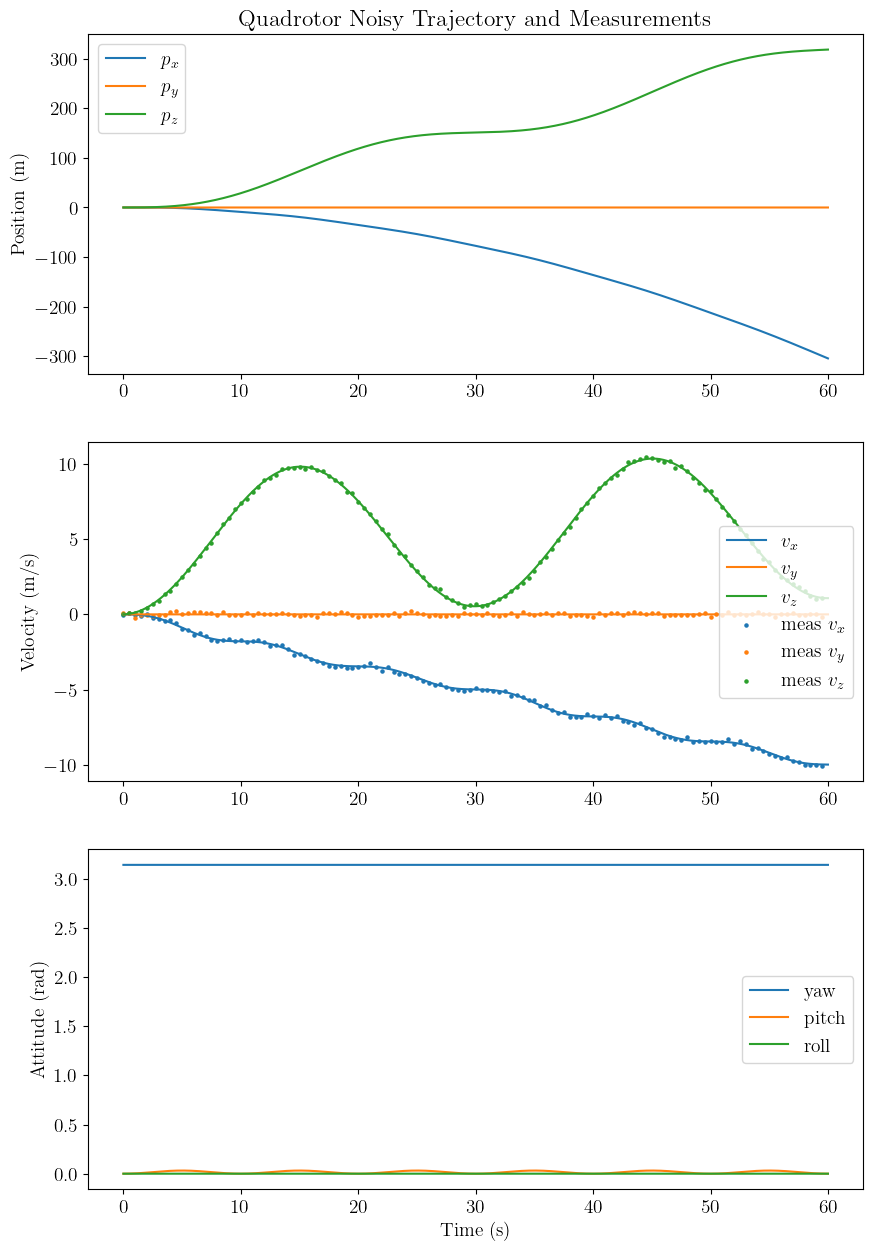

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, ax = plt.subplots(3, 1, figsize=(10,15))
ax[0].set_title("Quadrotor Noisy Trajectory and Measurements")
data = ref_traj2
ax[0].plot(t_span, data[:, 0], label=r'$p_x$')
ax[0].plot(t_span, data[:, 1], label=r'$p_y$')
ax[0].plot(t_span, data[:, 2], label=r'$p_z$')
ax[0].set_ylabel("Position (m)")
ax[0].legend()

ax[1].plot(t_span, data[:, 3], label=r'$v_x$')
ax[1].plot(t_span, data[:, 4], label=r'$v_y$')
ax[1].plot(t_span, data[:, 5], label=r'$v_z$')
ax[1].set_ylabel("Velocity (m/s)")

ax[1].legend()

ax[2].plot(t_span, data[:, 6], label=r'yaw')
ax[2].plot(t_span, data[:, 7], label=r'pitch')
ax[2].plot(t_span, data[:, 8], label=r'roll')
ax[2].set_ylabel("Attitude (rad)")
ax[2].legend()

data2 = meas
time_arr = meas_time_arr
ax[1].scatter(time_arr, data2[:, 0],s=5, label=f'meas $v_x$')
ax[1].scatter(time_arr, data2[:, 1],s=5, label=f'meas $v_y$')
ax[1].scatter(time_arr, data2[:, 2],s=5, label=f'meas $v_z$')
ax[1].legend()

# Save as PDF
output_file = '../../../examples/output/traj_meas.pdf'
plt.savefig(output_file, dpi=300, bbox_inches='tight', format='pdf')
print(f"Saved figure to: {output_file}")

plt.xlabel("Time (s)")
plt.plot()

### Define Dynamics with Estimator Matrix P

In [47]:
def A_fun(acc, omega):
    n_param = ca.vertcat(
        ca.SX.zeros(3, 1),           # v
        ca.DM(acc),              # a 
        ca.DM(omega)            # omega 
    )
    n = lie.se23.elem(n_param)
    Ad_n_sx = lie.se23.adjoint(n)
    ad = np.array(ca.DM(Ad_n_sx).full())
    A_C = np.zeros((9, 9))
    A_C[0:3, 3:6] = np.eye(3)
    A = -ad + A_C
 
    return A

def total_dynamics(t, state, controls, Q_hat):
        # State should be 106x1 vector:
        #        25x1 vector corresponding to State X SE23 Element
        #        81x1 vector corresponding to 9x9 matrix P
        X_flat = state[:25]
        P_flat = state[25:]
        X = X_flat.reshape(5,5)
        P =  P_flat.reshape(9,9)

        # Extract controls
        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]

        # State Dynamics
        g = [0,0,-9.81]
        M = np.zeros([5,5])
        M[0:3, 3] = g
        C = np.zeros((5,5))
        C[3,4] = 1
        
        skew_omega = np.array([[0, -omega[2], omega[1]],
                                [omega[2], 0, -omega[0]],
                                [-omega[1], omega[0], 0]])
        N = np.zeros([5,5])
        N[0:3,0:3] = skew_omega
        N[0:3,3] = a

        X_dot = (M-C)@X + X@(N+C)

        # P dynamics
        A = A_fun(a, omega)
        P_dot = A@P + P@A.T + Q_hat

        flat_X_dot = X_dot.flatten()
        flat_P_dot = P_dot.flatten()

        return np.concatenate([flat_X_dot,flat_P_dot])

def simulate_total_dynamics(t_span, state_0, controls,Q_hat,
                        rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lambda t, x: total_dynamics(t, x, controls, Q_hat),
        (t_span[0], t_span[-1]), state_0,
        dense_output=True, rtol=rtol, atol=atol
    )
    return np.array([sol.sol(t) for t in t_span])

In [ ]:
d_vec = d.reshape((5,1))

# Initial estimates
P0 = 100*np.eye(9)
P0_flat = P0.flatten()
x0_hat = x0 + np.array([0.00,00,0.00,0,0.0,0,0,0,0,0])
X0_hat_lie = lie.SE23Quat.elem(ca.DM(x0))
X0_hat = ca.DM(X0_lie.to_Matrix()).full()
X0_hat_flat = X0.flatten()

H = np.zeros((5,9))
H[:3, 3:6] = -np.eye(3)
print(H)

# Save History
P_hist = np.zeros((num_samples, 81))
X_hat_hist = np.zeros((num_samples, 25))

XP = np.concatenate([X0_hat_flat, P0_flat])
for i in range(num_samples):
    #1. Propogate to get priors
    # Integrator constants
    dt = 0.01
    t0 = sample_time*i
    tf = t0 + sample_time
    time = np.arange(t0,tf, dt)
    t_span_int = (time[0], time[-1])

    res = solve_ivp(
                    fun=lambda t,y: total_dynamics(t,y, controls, Q_hat),
                    t_span=t_span_int,
                    y0=XP,
                    t_eval=time,
            )
    XP_prior = res['y'][:,-1]
    X_hat_prior_flat = XP_prior[:25]
    P0_prior_flat = XP_prior[25:]

    X_hat_prior = X_hat_prior_flat.reshape((5,5))
    P_prior = P0_prior_flat.reshape((9,9))

    # 2. Gains
    S = H@P_prior@H.T + N_hat
    L = P_prior@H.T@np.linalg.pinv(S)
#   L = np.zeros(L.shape)

    # 3. Update prior to posterior
    update_P = np.eye(9,9) - (L@H)
    P_post = update_P@P_prior
    # sample we are updating with:
    Y = meas[i].reshape(5,1)
    X_inv = np.linalg.pinv(X_hat_prior)
    alg_vec = L@(X_inv@Y - d_vec) # This should be 9x1 corresponding to algebra vector

    alg_lie = lie.se23.elem(ca.SX(alg_vec))
    group_lie = lie.SE23Quat.exp(alg_lie)
    group_mat = ca.DM(group_lie.to_Matrix())
    X_hat_post = ca.DM(X_hat_prior)@group_mat  

    X_hat_post_flat = X_hat_post.full().flatten()
    P_post_flat = P_post.flatten()

    # save history
    X_hat_hist[i] = X_hat_post_flat
    P_hist[i] = P_post_flat
    
    # Update P, X_hat for next integration
    XP = np.concatenate([X_hat_post_flat, P_post_flat])


[[ 0.  0.  0. -1. -0. -0.  0.  0.  0.]
 [ 0.  0.  0. -0. -1. -0.  0.  0.  0.]
 [ 0.  0.  0. -0. -0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [58]:
x_hat_hist_quat = group_to_elem(X_hat_hist)
x_hat_hist = to_euler(x_hat_hist_quat)

In [99]:
print(P_hist[-1])

[ 1.00000121e+02  0.00000000e+00  0.00000000e+00 -1.69406589e-21
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.05882248e-08
  0.00000000e+00  0.00000000e+00  1.00000121e+02  0.00000000e+00
  0.00000000e+00 -1.69406589e-21  0.00000000e+00  2.05882248e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000121e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.05882251e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.71497170e-08  0.00000

### Plot against State and measurements

Saved figure to: ../../../examples/output/est_traj.pdf


[]

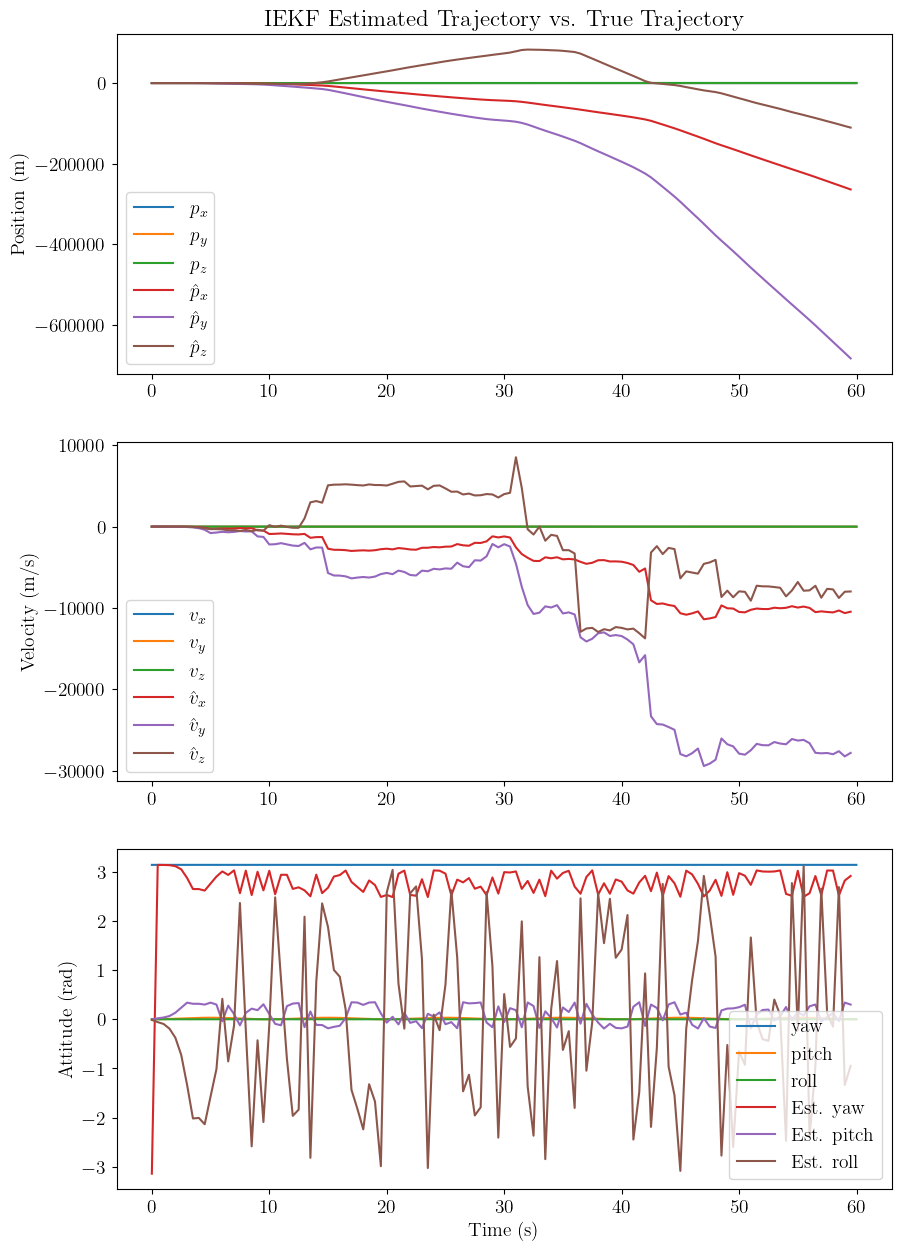

In [95]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

fig, ax = plt.subplots(3, 1, figsize=(10,15))
ax[0].set_title("IEKF Estimated Trajectory vs. True Trajectory")
data = traj2
ax[0].plot(t_span, data[:, 0], label=r'$p_x$')
ax[0].plot(t_span, data[:, 1], label=r'$p_y$')
ax[0].plot(t_span, data[:, 2], label=r'$p_z$')
ax[0].legend()

ax[1].plot(t_span, data[:, 3], label=r'$v_x$')
ax[1].plot(t_span, data[:, 4], label=r'$v_y$')
ax[1].plot(t_span, data[:, 5], label=r'$v_z$')
ax[1].legend()

ax[2].plot(t_span, data[:, 6], label=r'yaw')
ax[2].plot(t_span, data[:, 7], label=r'pitch')
ax[2].plot(t_span, data[:, 8], label=r'roll')
ax[2].legend()

# data2 = meas
# time_arr = meas_time_arr
# ax[1].scatter(time_arr, data2[:, 0],s=5, label=r'meas v_x')
# ax[1].scatter(time_arr, data2[:, 1],s=5, label=r'meas v_y')
# ax[1].scatter(time_arr, data2[:, 2],s=5, label=r'meas v_z')
# ax[1].legend()

data3 = x_hat_hist
time_arr = meas_time_arr
ax[0].plot(time_arr, data3[:, 0], label=r'$\hat{p}_x$')
ax[0].plot(time_arr, data3[:, 1], label=r'$\hat{p}_y$')
ax[0].plot(time_arr, data3[:, 2], label=r'$\hat{p}_z$')
ax[0].legend()

ax[1].plot(time_arr, data3[:, 3], label=r'$\hat{v}_x$')
ax[1].plot(time_arr, data3[:, 4], label=r'$\hat{v}_y$')
ax[1].plot(time_arr, data3[:, 5], label=r'$\hat{v}_z$')
ax[1].legend()

ax[2].plot(time_arr, data3[:, 6], label=r'Est. yaw')
ax[2].plot(time_arr, data3[:, 7], label=r'Est. pitch')
ax[2].plot(time_arr, data3[:, 8], label=r'Est. roll')
ax[2].legend()

ax[1].set_ylabel("Velocity (m/s)")
ax[0].set_ylabel("Position (m)")
ax[2].set_ylabel("Attitude (rad)")
plt.plot()

# Save as PDF
output_file = '../../../examples/output/est_traj.pdf'
plt.savefig(output_file, dpi=300, bbox_inches='tight', format='pdf')
print(f"Saved figure to: {output_file}")

plt.xlabel("Time (s)")
plt.plot()

### Compute Error

In [35]:
actual_points = np.zeros((meas_time_arr.shape[0], 25))
for i in range(0, traj_flat.shape[0], sample_period):
    actual_points[int(i/sample_period)] = traj_flat[i]

actual_points_quat = group_to_elem(actual_points)
actual_points_euler = to_euler(actual_points_quat)

In [36]:
est_error = actual_points_euler - x_hat_hist

[]

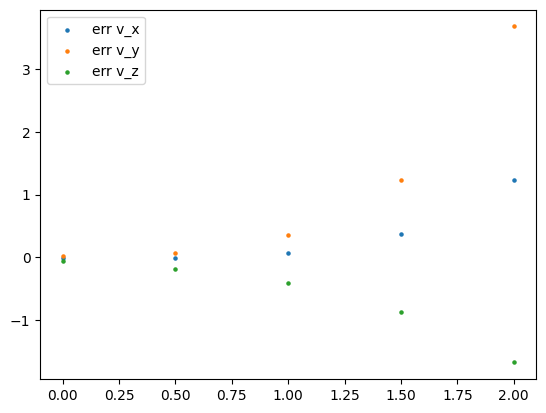

In [37]:
data2 = est_error[:5]
time_arr = meas_time_arr[:5]
ax = plt.gca()
ax.scatter(time_arr, data2[:, 0],s=5, label=r'err v_x')
ax.scatter(time_arr, data2[:, 1],s=5, label=r'err v_y')
ax.scatter(time_arr, data2[:, 2],s=5, label=r'err v_z')
ax.legend()
plt.plot()